In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path

In [9]:
plt.rc('font', size=14)
plt.rc('axes', labelsize=14, titlesize=14)
plt.rc('legend', fontsize=14)
plt.rc('xtick', labelsize=10)
plt.rc('ytick', labelsize=10)

In [10]:
IMAGES_PATH = Path() / "images" / "classification"
IMAGES_PATH.mkdir(parents=True, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = IMAGES_PATH / f"{fig_id}.{fig_extension}"
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

In [11]:
from sklearn.datasets import fetch_openml

mnist = fetch_openml('mnist_784', as_frame=False)

X, y = mnist.data, mnist.target

X.shape, y.shape

((70000, 784), (70000,))

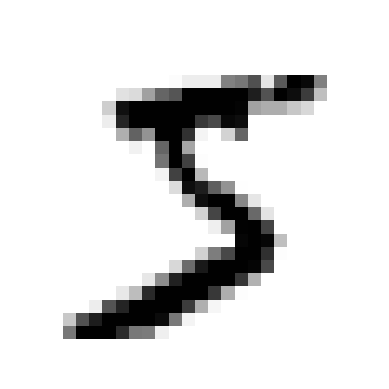

In [12]:
def plot_digit(image_data):
    image = image_data.reshape(28, 28)
    plt.imshow(image, cmap="binary")
    plt.axis("off")

some_digit = X[0]
plot_digit(some_digit)
plt.show()

In [13]:
# Data is already shuffled and split

X_train, X_test, y_train, y_test = X[:60000], X[60000:], y[:60000], y[60000:]
y_train_5 = (y_train == '5') # True for all 5s, False for all other digits
y_test_5 = (y_test == '5')

In [14]:
from sklearn.linear_model import SGDClassifier

sgd_clf = SGDClassifier(random_state=42)
sgd_clf.fit(X_train, y_train_5)

SGDClassifier(random_state=42)

In [15]:
from sklearn.model_selection import cross_val_score

cross_val_score(sgd_clf, X_train, y_train_5, cv=3, scoring="accuracy")

array([0.95035, 0.96035, 0.9604 ])

### Confusion Matrix

In [16]:
from sklearn.model_selection import cross_val_predict

y_train_pred = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3)

In [17]:
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_train_5, y_train_pred)

cm

array([[53892,   687],
       [ 1891,  3530]])

In [18]:
from sklearn.metrics import precision_score, recall_score

print(precision_score(y_train_5, y_train_pred)) # == 3530 / (687 + 3530)
print(recall_score(y_train_5, y_train_pred)) # == 3530 / (1891 + 3530)

0.8370879772350012
0.6511713705958311


In [19]:
from sklearn.metrics import f1_score

f1_score(y_train_5, y_train_pred)

0.7325171197343847

In [20]:
# method=decision_function returns decision score instead of prediction
y_scores = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3, method="decision_function")

y_scores[:5]

array([  1200.93051237, -26883.79202424, -33072.03475406, -15919.5480689 ,
       -20003.53970191])

### PR Curve

In [21]:
from sklearn.metrics import precision_recall_curve

precisions, recalls, thresholds = precision_recall_curve(y_train_5, y_scores)

In [22]:
len(recalls)

60001

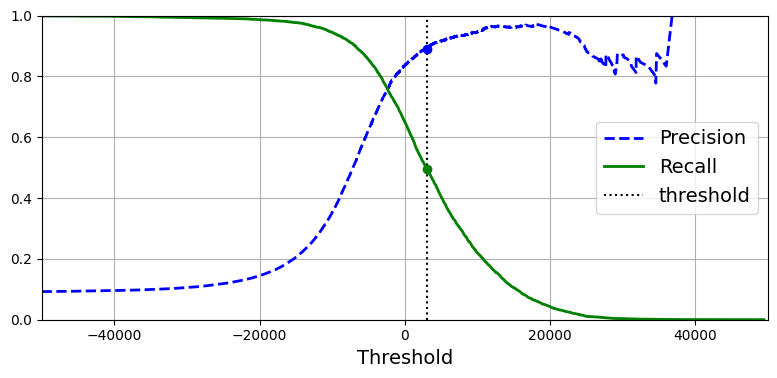

In [23]:
threshold = 3000

plt.figure(figsize=(8, 4))  # extra code – it's not needed, just formatting
plt.plot(thresholds, precisions[:-1], "b--", label="Precision", linewidth=2)
plt.plot(thresholds, recalls[:-1], "g-", label="Recall", linewidth=2)
plt.vlines(threshold, 0, 1.0, "k", "dotted", label="threshold")

# extra code – this section just beautifies and saves Figure 3–5
idx = (thresholds >= threshold).argmax()  # first index ≥ threshold
plt.plot(thresholds[idx], precisions[idx], "bo")
plt.plot(thresholds[idx], recalls[idx], "go")
plt.axis([-50000, 50000, 0, 1])
plt.grid()
plt.xlabel("Threshold")
plt.legend(loc="center right")
save_fig("precision_recall_vs_threshold_plot")

plt.show()

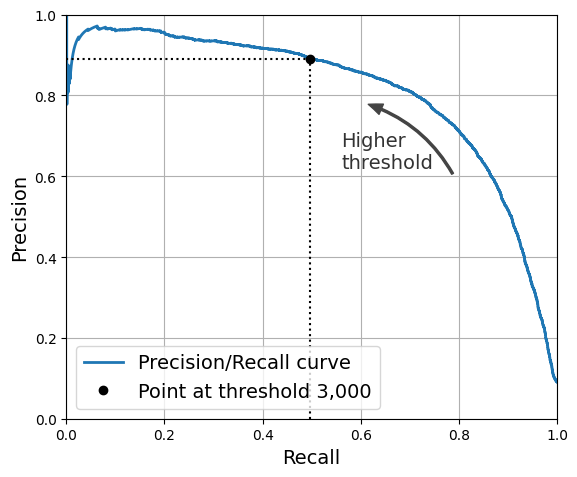

In [24]:
import matplotlib.patches as patches  # extra code – for the curved arrow

plt.figure(figsize=(6, 5))  # extra code – not needed, just formatting

plt.plot(recalls, precisions, linewidth=2, label="Precision/Recall curve")

# extra code – just beautifies and saves Figure 3–6
plt.plot([recalls[idx], recalls[idx]], [0., precisions[idx]], "k:")
plt.plot([0.0, recalls[idx]], [precisions[idx], precisions[idx]], "k:")
plt.plot([recalls[idx]], [precisions[idx]], "ko",
         label="Point at threshold 3,000")
plt.gca().add_patch(patches.FancyArrowPatch(
    (0.79, 0.60), (0.61, 0.78),
    connectionstyle="arc3,rad=.2",
    arrowstyle="Simple, tail_width=1.5, head_width=8, head_length=10",
    color="#444444"))
plt.text(0.56, 0.62, "Higher\nthreshold", color="#333333")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.axis([0, 1, 0, 1])
plt.grid()
plt.legend(loc="lower left")
save_fig("precision_vs_recall_plot")

plt.show()

In [25]:
idx_for_90_precision = (precisions >= 0.90).argmax()
threshold_for_90_precision = thresholds[idx_for_90_precision]
threshold_for_90_precision

np.float64(3370.019499144183)

In [26]:
y_train_pred_90 = (y_scores >= threshold_for_90_precision)

In [27]:
precision_score(y_train_5, y_train_pred_90)

0.9000345901072293

In [28]:
recall_at_90_precision = recall_score(y_train_5, y_train_pred_90)
recall_at_90_precision

0.4799852425751706

### ROC Curve

In [29]:
from sklearn.metrics import roc_curve

fpr, tpr, thresholds = roc_curve(y_train_5, y_scores)

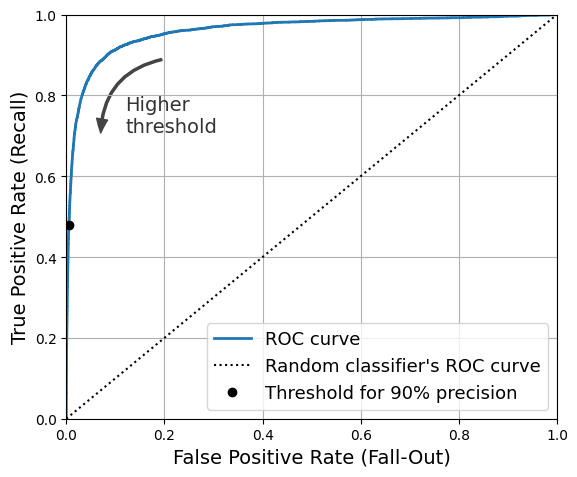

In [30]:
idx_for_threshold_at_90 = (thresholds <= threshold_for_90_precision).argmax()
tpr_90, fpr_90 = tpr[idx_for_threshold_at_90], fpr[idx_for_threshold_at_90]

plt.figure(figsize=(6, 5))  # extra code – not needed, just formatting
plt.plot(fpr, tpr, linewidth=2, label="ROC curve")
plt.plot([0, 1], [0, 1], 'k:', label="Random classifier's ROC curve")
plt.plot([fpr_90], [tpr_90], "ko", label="Threshold for 90% precision")

# extra code – just beautifies and saves Figure 3–7
plt.gca().add_patch(patches.FancyArrowPatch(
    (0.20, 0.89), (0.07, 0.70),
    connectionstyle="arc3,rad=.4",
    arrowstyle="Simple, tail_width=1.5, head_width=8, head_length=10",
    color="#444444"))
plt.text(0.12, 0.71, "Higher\nthreshold", color="#333333")
plt.xlabel('False Positive Rate (Fall-Out)')
plt.ylabel('True Positive Rate (Recall)')
plt.grid()
plt.axis([0, 1, 0, 1])
plt.legend(loc="lower right", fontsize=13)
save_fig("roc_curve_plot")

plt.show()

In [31]:
from sklearn.metrics import roc_auc_score
roc_auc_score(y_train_5, y_scores)

np.float64(0.9604938554008616)

In [32]:
from sklearn.ensemble import RandomForestClassifier

forest_clf = RandomForestClassifier(random_state=42)

y_probas_forest = cross_val_predict(forest_clf, X_train, y_train_5, cv=3, method="predict_proba")

# each row is [negative class prob, positive class prob]
y_probas_forest[:2]

array([[0.11, 0.89],
       [0.98, 0.02]])

In [33]:
y_scores_forest = y_probas_forest[:, 1]
precisions_forest, recalls_forest, thresholds_forest = precision_recall_curve(y_train_5, y_scores_forest)

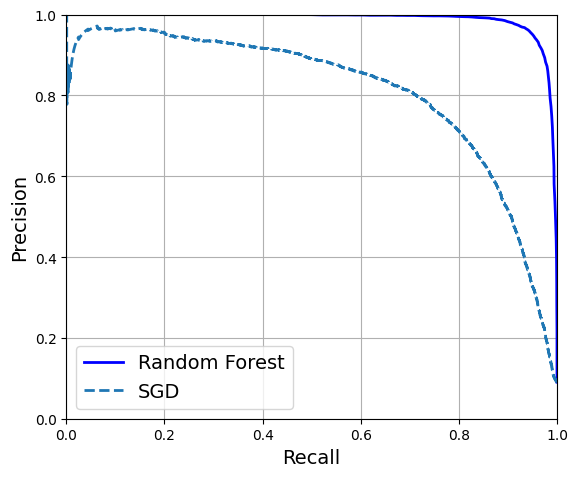

In [34]:
plt.figure(figsize=(6, 5))  # extra code – not needed, just formatting

plt.plot(recalls_forest, precisions_forest, "b-", linewidth=2,
         label="Random Forest")
plt.plot(recalls, precisions, "--", linewidth=2, label="SGD")

# extra code – just beautifies and saves Figure 3–8
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.axis([0, 1, 0, 1])
plt.grid()
plt.legend(loc="lower left")
save_fig("pr_curve_comparison_plot")

plt.show()

In [35]:
y_train_pred_forest = y_scores_forest >= 0.5  # positive proba ≥ 50%

print(f'f1 score: {f1_score(y_train_5, y_train_pred_forest)}\n')
print(f'roc auc score: {roc_auc_score(y_train_5, y_train_pred_forest)}\n')

f1 score: 0.9270445185330457

roc auc score: 0.9355316181710396


In [36]:
precision_score(y_train_5, y_train_pred_forest)

0.9895331798199707

In [37]:
recall_score(y_train_5, y_train_pred_forest)

0.8719793396052389

# Multi-class

In [38]:
from sklearn.svm import SVC

svm_clf = SVC(random_state=42)
svm_clf.fit(X_train[:2000], y_train[:2000])  # y_train, not y_train_5

SVC(random_state=42)

In [39]:
svm_clf.predict([some_digit])

array(['5'], dtype=object)

In [40]:
some_digit_scores = svm_clf.decision_function([some_digit])
some_digit_scores.round(2)

array([[ 3.79,  0.73,  6.06,  8.3 , -0.29,  9.3 ,  1.75,  2.77,  7.21,
         4.82]])

In [41]:
class_id = some_digit_scores.argmax()
class_id

np.int64(5)

In [42]:
svm_clf.classes_

array(['0', '1', '2', '3', '4', '5', '6', '7', '8', '9'], dtype=object)

In [43]:
svm_clf.classes_[class_id]

'5'

In [44]:
from sklearn.multiclass import OneVsRestClassifier

ovr_clf = OneVsRestClassifier(SVC(random_state=42))
ovr_clf.fit(X_train[:2000], y_train[:2000])

OneVsRestClassifier(estimator=SVC(random_state=42))

In [45]:
ovr_clf.predict([some_digit])

array(['5'], dtype='<U1')

In [46]:
len(ovr_clf.estimators_)

10

In [47]:
sgd_clf = SGDClassifier(random_state=42)
sgd_clf.fit(X_train, y_train)
sgd_clf.predict([some_digit])

array(['3'], dtype='<U1')

In [48]:
# wrong answer above! let's examine
sgd_clf.decision_function([some_digit]).round()

array([[-31893., -34420.,  -9531.,   1824., -22320.,  -1386., -26189.,
        -16148.,  -4604., -12051.]])

In [49]:
# Still better than a random classifier
cross_val_score(sgd_clf, X_train, y_train, cv=3, scoring="accuracy")

array([0.87365, 0.85835, 0.8689 ])

# Multilabel

In [50]:
from sklearn.neighbors import KNeighborsClassifier

y_train_large = (y_train >= '7')
y_train_odd = (y_train.astype('int8') % 2 == 1)
y_multilabel = np.c_[y_train_large, y_train_odd]

knn_clf = KNeighborsClassifier()
knn_clf.fit(X_train, y_multilabel)

KNeighborsClassifier()

In [51]:
knn_clf.predict([some_digit]) # should be [false, true]

array([[False,  True]])

In [52]:
y_train_knn_pred = cross_val_predict(knn_clf, X_train, y_multilabel, cv=3)
# Macro assumes that each label is equally weighted
f1_score(y_multilabel, y_train_knn_pred, average="macro")

0.9764102655606048

In [53]:
from sklearn.multioutput import ClassifierChain

chain_clf = ClassifierChain(SVC(), cv=3, random_state=42)
chain_clf.fit(X_train[:2000], y_multilabel[:2000])

ClassifierChain(base_estimator=SVC(), cv=3, random_state=42)

In [54]:
chain_clf.predict([some_digit])

array([[0., 1.]])

# Multioutput

In [55]:
# Essentially we treat the 784 cells with values from 0-255 as our "multi-output"
# Sometimes this can be confused with regression
np.random.seed(42)
noise = np.random.randint(0, 100, (len(X_train), 784))
X_train_mod = X_train + noise
noise = np.random.randint(0, 100, (len(X_test), 784))
X_test_mod = X_test + noise
y_train_mod = X_train
y_test_mod = X_test

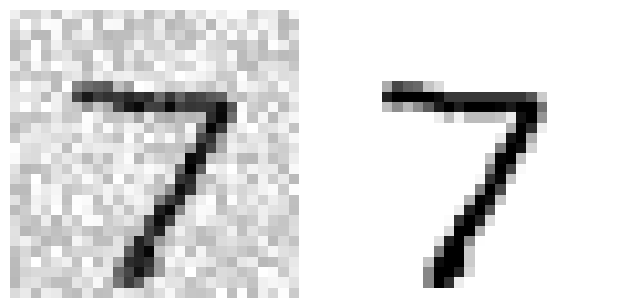

In [56]:
# extra code
plt.subplot(121); plot_digit(X_test_mod[0])
plt.subplot(122); plot_digit(y_test_mod[0])
save_fig("noisy_digit_example_plot")
plt.show()

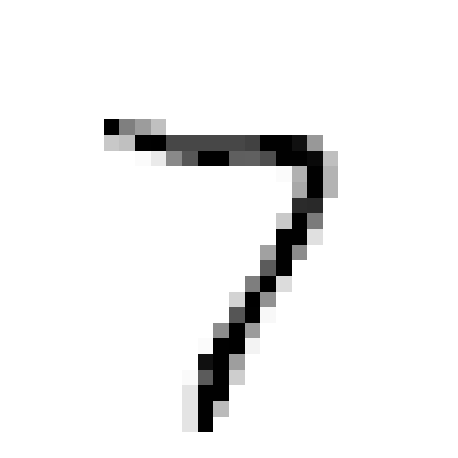

In [57]:
knn_clf = KNeighborsClassifier()
knn_clf.fit(X_train_mod, y_train_mod)
clean_digit = knn_clf.predict([X_test_mod[0]])
plot_digit(clean_digit)
save_fig("cleaned_digit_example_plot")  # extra code – saves Figure 3–13
plt.show()

# Exercises

### 1 Grid Search

In [59]:
from sklearn.model_selection import GridSearchCV

param_grid = {
    'n_neighbors': [3, 5, 7],
    'weights': ['uniform', 'distance']
}

grid_search = GridSearchCV(KNeighborsClassifier(), param_grid, cv=3, scoring='accuracy')
grid_search.fit(X_train, y_train)

GridSearchCV(cv=3, estimator=KNeighborsClassifier(),
             param_grid={'n_neighbors': [3, 5, 7],
                         'weights': ['uniform', 'distance']},
             scoring='accuracy')

In [60]:
grid_search.best_params_

{'n_neighbors': 3, 'weights': 'distance'}

In [62]:
cv_res = pd.DataFrame(grid_search.cv_results_)
cv_res.sort_values(by='mean_test_score', ascending=False, inplace=True)

cv_res.head(5)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_n_neighbors,param_weights,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score
1,0.098785,0.022699,6.797052,0.210212,3,distance,"{'n_neighbors': 3, 'weights': 'distance'}",0.9704,0.96890,0.96870,0.969333,0.000759,1
3,0.092882,0.009159,11.759742,0.277315,5,distance,"{'n_neighbors': 5, 'weights': 'distance'}",0.9688,0.96795,0.96905,0.968600,0.000471,2
0,0.205109,0.139070,7.894080,1.276307,3,uniform,"{'n_neighbors': 3, 'weights': 'uniform'}",0.9690,0.96805,0.96750,0.968183,0.000620,3
2,0.095223,0.019005,12.148553,0.413172,5,uniform,"{'n_neighbors': 5, 'weights': 'uniform'}",0.9676,0.96710,0.96755,0.967417,0.000225,4
5,0.094524,0.009259,11.865171,0.255046,7,distance,"{'n_neighbors': 7, 'weights': 'distance'}",0.9670,0.96560,0.96740,0.966667,0.000772,5


In [67]:
y_test_pred = grid_search.best_estimator_.predict(X_test)

y_test_pred[:3]

array(['7', '2', '1'], dtype=object)

In [68]:
cm = confusion_matrix(y_test, y_test_pred)

cm

array([[ 974,    1,    1,    0,    0,    1,    2,    1,    0,    0],
       [   0, 1133,    2,    0,    0,    0,    0,    0,    0,    0],
       [   9,    7,  997,    2,    0,    0,    1,   14,    2,    0],
       [   0,    1,    4,  975,    1,   13,    1,    7,    4,    4],
       [   0,    5,    0,    0,  948,    0,    5,    4,    1,   19],
       [   4,    1,    0,   12,    2,  860,    5,    1,    3,    4],
       [   4,    3,    0,    0,    4,    3,  944,    0,    0,    0],
       [   0,   18,    4,    0,    2,    0,    0,  994,    0,   10],
       [   7,    0,    3,   13,    5,   11,    3,    4,  923,    5],
       [   3,    4,    2,    7,    9,    4,    1,    8,    2,  969]])

In [70]:
f1_score(y_test, y_test_pred, average='macro')

0.971528765919764

### 2 Titanic

The goal is to train a classifier that can predict the "Survived" column based on the other columns

In [71]:
import urllib.request
import tarfile

def load_and_unzip_titanic_data():
    tarball_path = Path("datasets/titanic.tgz")
    if not tarball_path.is_file():
        Path("datasets").mkdir(parents=True, exist_ok=True)
        url = "https://github.com/ageron/data/raw/main/titanic.tgz"
        urllib.request.urlretrieve(url, tarball_path)
    with tarfile.open(tarball_path) as data_tarball:
        data_tarball.extractall(path="datasets")

load_and_unzip_titanic_data()

/var/folders/p6/6cbftr8s4fq53_2vhd4fks6r0000gn/T/ipykernel_51690/3675554206.py:11: DeprecationWarning: Python 3.14 will, by default, filter extracted tar archives and reject files or modify their metadata. Use the filter argument to control this behavior.
  data_tarball.extractall(path="datasets")


In [136]:
titanic_df = pd.read_csv('datasets/titanic/train.csv')

titanic_df.head(5)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [197]:
# shuffle and split training data since the test data doesn't contain ground truth
from sklearn.model_selection import train_test_split

strat_train_set, strat_test_set = train_test_split(titanic_df, test_size=0.2, stratify=titanic_df['Survived'], random_state=42)

In [198]:
X_cols = ['Pclass', 'Sex', 'Age', 'SibSp', 'Parch', 'Fare', 'Embarked']
y_cols = ['Survived']

# Drop the embarked=NaN rows before preprocessing
strat_train_set.dropna(subset=['Embarked'], inplace=True)
strat_test_set.dropna(subset=['Embarked'], inplace=True)

train_X_df = strat_train_set[X_cols]
train_y_df = strat_train_set[y_cols]
test_X_df = strat_test_set[X_cols]
test_y_df = strat_test_set[y_cols]

In [199]:
train_X_df.head(2)

,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
692,3,male,NaN,0,0,56.4958,S
481,2,male,NaN,0,0,0.0000,S


array([[<Axes: title={'center': 'Pclass'}>,
        <Axes: title={'center': 'Age'}>],
       [<Axes: title={'center': 'SibSp'}>,
        <Axes: title={'center': 'Parch'}>],
       [<Axes: title={'center': 'Fare'}>, <Axes: >]], dtype=object)

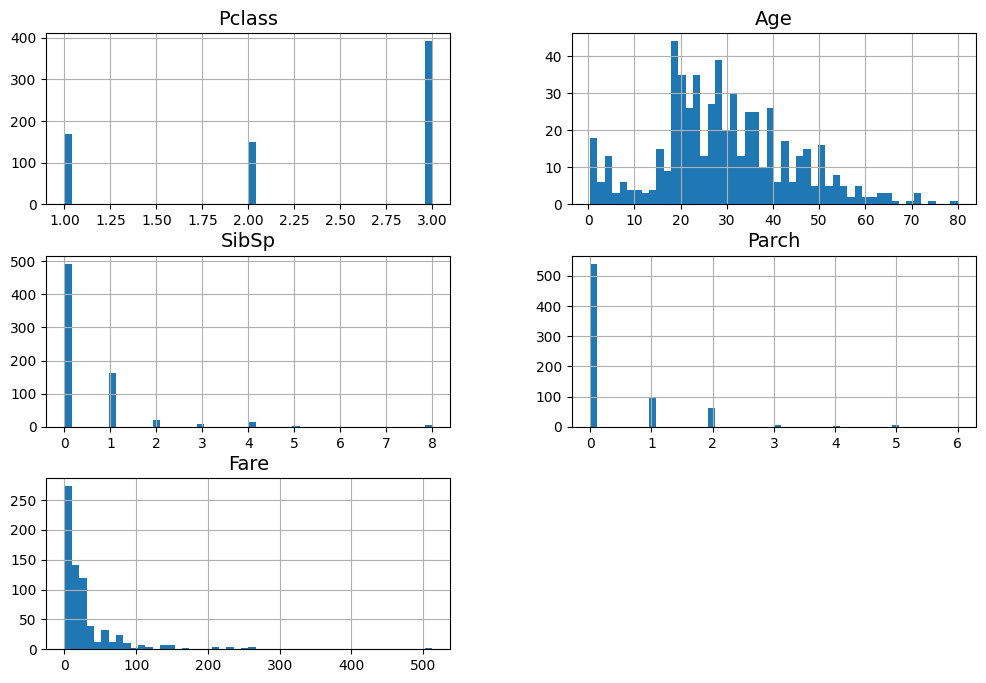

In [201]:
train_X_df.hist(bins=50, figsize=(12, 8))

In [202]:
from functools import partial
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import FunctionTransformer, OneHotEncoder, StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.compose import ColumnTransformer

def sqrt_col(col: str, df: pd.DataFrame) -> pd.DataFrame:
    df[col] = np.sqrt(df[col])
    
    return df

age_pipeline = make_pipeline(
    SimpleImputer(strategy='median'),
    StandardScaler()
)

fare_pipeline = make_pipeline(
    FunctionTransformer(partial(sqrt_col, 'Fare'), check_inverse=False, feature_names_out='one-to-one'), # sqrt to fix the skew right
    StandardScaler()
)

preprocessing = ColumnTransformer([
    ('cat', OneHotEncoder(handle_unknown="ignore", sparse_output=False), ['Pclass', 'Sex', 'Embarked']),
    ('num', StandardScaler(), ['SibSp', 'Parch', 'Fare']),
    ('fare', fare_pipeline, ['Fare']),
    ('age', age_pipeline, ['Age'])
])

In [203]:
train_prepared = preprocessing.fit_transform(train_X_df)
print(train_prepared.shape)

(710, 13)


In [204]:
preprocessing.get_feature_names_out()

array(['cat__Pclass_1', 'cat__Pclass_2', 'cat__Pclass_3',
       'cat__Sex_female', 'cat__Sex_male', 'cat__Embarked_C',
       'cat__Embarked_Q', 'cat__Embarked_S', 'num__SibSp', 'num__Parch',
       'num__Fare', 'fare__Fare', 'age__Age'], dtype=object)

In [205]:
# extra code – shows that we can get a DataFrame out if we want
train_prepared_df = pd.DataFrame(
    train_prepared,
    columns=preprocessing.get_feature_names_out(),
    index=train_X_df.index)

train_prepared_df

,cat__Pclass_1,cat__Pclass_2,cat__Pclass_3,cat__Sex_female,cat__Sex_male,cat__Embarked_C,cat__Embarked_Q,cat__Embarked_S,num__SibSp,num__Parch,num__Fare,fare__Fare,age__Age
692,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,-0.465881,-0.466982,0.516644,0.926493,-0.076963
481,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,-0.465881,-0.466982,-0.659746,-1.651010,-0.076963
527,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,-0.465881,-0.466982,3.958276,3.455821,-0.076963
855,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,-0.465881,0.725670,-0.465054,-0.602442,-0.886307
801,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.476499,0.725670,-0.113152,0.105925,0.115738
...,...,...,...,...,...,...,...,...,...,...,...,...,...
359,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,-0.465881,-0.466982,-0.495680,-0.688441,-0.076963
258,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,-0.465881,-0.466982,10.008286,6.110846,0.424060
736,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.476499,3.110975,0.056031,0.359528,1.426106
462,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,-0.465881,-0.466982,0.141925,0.476744,1.349025


In [208]:
train_survived = train_y_df['Survived'].to_numpy()

print(f'Survivor count {(train_survived == 1).sum()}')
print(f'Death count {(train_survived == 0).sum()}')

Survivor count 271
Death count 439


In [209]:
sgd_clf_t = SGDClassifier(random_state=42)
sgd_clf_t.fit(train_prepared, train_survived)

SGDClassifier(random_state=42)

In [212]:
train_survived_pred = cross_val_predict(sgd_clf_t, train_prepared, train_survived, cv=3)

In [213]:
cm = confusion_matrix(train_survived, train_survived_pred)

cm

array([[357,  82],
       [ 95, 176]])

In [214]:
precision_score(train_survived, train_survived_pred)

0.6821705426356589

In [215]:
recall_score(train_survived, train_survived_pred)

0.6494464944649446

In [216]:
f1_score(train_survived, train_survived_pred)

0.665406427221172

In [218]:
precisions_sur, recalls_sur, thresholds_sur = precision_recall_curve(train_survived, train_survived_pred)

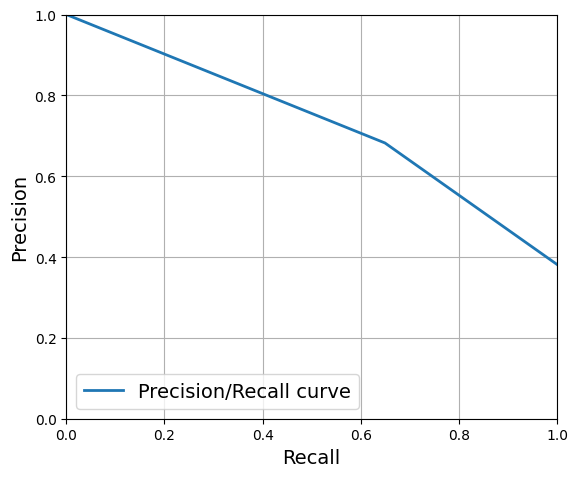

In [219]:
plt.figure(figsize=(6, 5))  # extra code – not needed, just formatting

plt.plot(recalls_sur, precisions_sur, linewidth=2, label="Precision/Recall curve")

# extra code – just beautifies and saves Figure 3–6
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.axis([0, 1, 0, 1])
plt.grid()
plt.legend(loc="lower left")
save_fig("titanic_precision_vs_recall_plot")

plt.show()
